# Final Project: Movie Recommender System using BERT Model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import Linear
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from rec_utils import *
from typing import Optional
import warnings
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
warnings.filterwarnings("ignore")

## Intoduction

### Problem Description

Recommendation algorithms are crucial for digital services like Netflix, Amazon and YouTube, offering personalized suggestions based on user behavior and preferences. These data-driven systems are indispensable for improving user satisfaction and engagement, driving successful digital services. In the movie industry, recommender systems provide personalized movie suggestions, enhancing the overall viewing experience.

In this final project, we will use the well-known Transformer method to build a movie recommender system. Transformer is a deep learning neural network architecture widely used in natural language processing tasks and has surpassed other models in many benchmark tests. With its self-attention mechanisms, it is capable of capturing contextual relationships among words in a sentence. By implementing a transformer-based recommender system, we aim to provide more accurate and personalized recommendations for users, enhancing their satisfaction and engagement with the platform.

### Dataset Description

The dataset used in this project is the `movielens-100k` dataset collected by the GroupLens Research Project at the University of Minnesota between September 1997 and April 1998. To ensure data quality, users with incomplete demographic information or less than 20 movie ratings were removed. For more information on this dataset, please refer to the paper titled "[The MovieLens Datasets: History and Context.](https://dl.acm.org/doi/10.1145/2827872)". This dataset consists of 100,000 ratings (1-5) provided by 943 users on 1,682 movies. Each user has rated a minimum of 20 movies, and the dataset also includes basic demographic information of users, such as age, gender, occupation, and zip code.

The main data files included in this dataset and their descriptions are as follows:
1. u.data -- This file contains the full u dataset comprising 100,000 ratings provided by 943 users on 1682 items.
2. u.info -- This file lists the number of users, items, and ratings included in the u dataset.
3. u.item -- Information on the items (movies) in the dataset is provided in this file.
4. u.genre -- This file contains a list of movie genres included in the dataset.
5. u.user -- This file includes demographic information about the users in the dataset.

## Exploratory Data Analysis

As our model is primarily trained on `u.data`, we conducted a detailed Exploratory Data Analysis (EDA) on this dataset.

In [3]:
## load the u.data
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("./ml-100k/u.data",sep="\t",names=columns_name)
print(len(df))
display(df.head(2))

100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


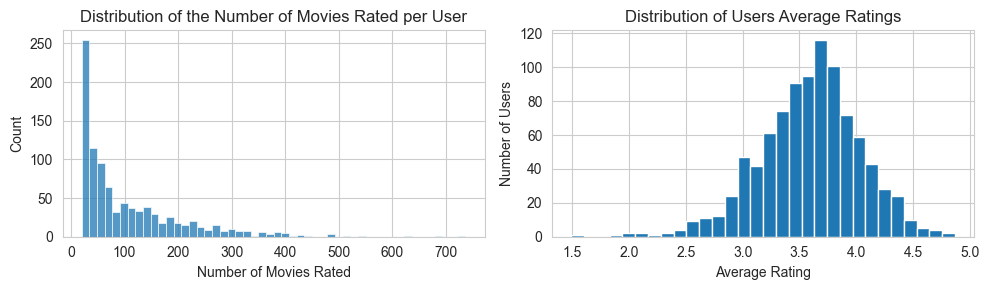

In [4]:
# Count the number of movies each user rated and plot histogram
user_movie_count = (df.groupby('user_id')['item_id'].count().reset_index()
                    .rename(columns={'item_id': 'Num_movies_rated'}))
sns.set_style('whitegrid')

plt.figure(figsize=(10,3))
plt.subplot(121)
sns.histplot(data=user_movie_count, x='Num_movies_rated', bins=50)
plt.xlabel('Number of Movies Rated')
plt.ylabel('Count')
plt.title('Distribution of the Number of Movies Rated per User')

# Find the average rating for each user
user_ratings = df.groupby('user_id')['rating'].mean().reset_index()

# Plot the distribution of average ratings
plt.subplot(122)
plt.hist(user_ratings['rating'], bins=30)
plt.title('Distribution of Users Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.show()

**Insights:**

1. Based on the plots presented above, we can observe that the average number of movies rated per user is approximately 100. Additionally, two-thirds of the users have rated more than 50 movies. This observation can inspire us to create a personalized movie recommendation system **based on users' rating histories using sequence methods**.

2. The normal distribution of average ratings implies that the ratings are reliable and reasonable as most ratings are concentrated around the mean value, and extreme values are infrequent. This observation suggests that there is **no need for extensive data cleaning**, manipulation, or normalization of the ratings for data modeling or analysis.



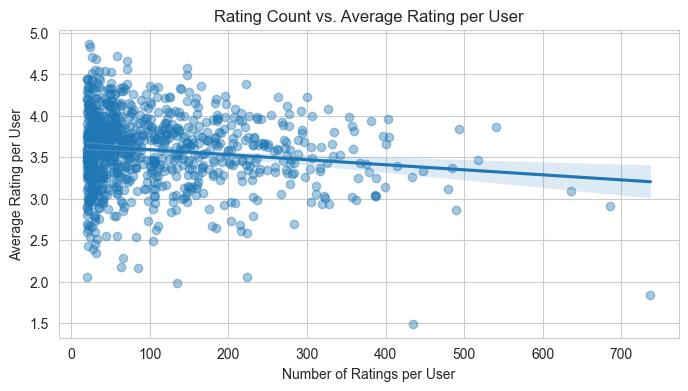

Correlation coefficient: -0.137795081429608


In [5]:
# Calculate the average rating and number of ratings for each user
user_ratings = df.groupby('user_id')['rating'].agg(['mean', 'count'])

# Plot the scatter plot of average rating vs. number of ratings per user
plt.figure(figsize=(8, 4))
sns.regplot(x="count", y="mean", data=user_ratings, scatter_kws={'alpha': 0.4})
plt.title('Rating Count vs. Average Rating per User')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Average Rating per User')
plt.show()

# Calculate Pearson correlation coefficient between rating count and average rating per user
correlation = user_ratings['count'].corr(user_ratings['mean'], method='pearson')
print('Correlation coefficient:', correlation)


**Insights:**

The scatter plot demonstrates that there is no correlation between the number of movie ratings a user gives and their actual rating scores. This suggests that users give independent and unbiased ratings based on the quality and entertainment value of the movies rather than being influenced by the number of ratings they have given. The implication of this observation is that it is possible to use algorithms based on the assumption of independent and identically distributed data to analyze and predict what types of movies users like to watch more fairly.

In [6]:
item_df = pd.read_csv('./ml-100k/u.item', delimiter='|', encoding='ISO-8859-1', header=None,
                      names=['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown',
                             'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
                             'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                             'Thriller', 'War', 'Western'])
item_count_df = df.groupby(['item_id']).count().reset_index()
item_count_df = item_count_df.rename(columns={'rating': 'count'})
item_count_df = item_count_df.sort_values('count', ascending=False)
top_movies = item_count_df.merge(item_df, left_on='item_id', right_on='movie id')[['movie title', 'count']]

print(top_movies[:10])

                     movie title  count
0               Star Wars (1977)    583
1                 Contact (1997)    509
2                   Fargo (1996)    508
3      Return of the Jedi (1983)    507
4               Liar Liar (1997)    485
5    English Patient, The (1996)    481
6                  Scream (1996)    478
7               Toy Story (1995)    452
8           Air Force One (1997)    431
9  Independence Day (ID4) (1996)    429


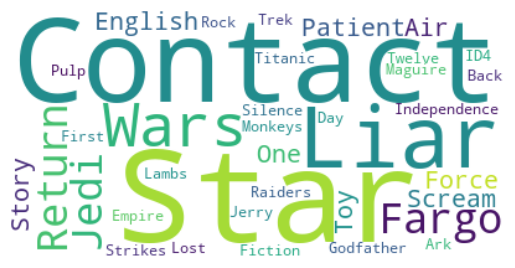

In [7]:
movie_count = df.groupby(['item_id']).size().rename('count').reset_index()
movie_count = movie_count.sort_values('count', ascending=False)
top_movies = movie_count.head(20)['item_id'].map(item_df.set_index('movie id')['movie title'])
text = " ".join(title for title in top_movies)
wordcloud = WordCloud(stopwords=set(STOPWORDS), background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Model Training

### Problem

From the above analysis, we have found that movie recommendation systems can be built based on historical sequence ratings. 

Our goal is to personalize the movie recommendation process for each user based on the history of the movies they have previously watched. To achieve this, we aim to build a movie recommendation system that learns directly from the user's data. By doing so, we can provide personalized movie recommendations to each user.

![image.png](https://miro.medium.com/v2/resize:fit:640/format:webp/1*BiByPdyN8EaJsTwedw_sfg.png)

### BERT4Rec

In order to implement this approach, we have decided to use the `BERT4Rec` model as it has been shown to be effective in similar problems (source: https://arxiv.org/pdf/1904.06690.pdf).

`BERT` model, short for `Bidirectional Encoder Representations from Transformers`, is a pre-trained natural language processing model. During the pre-training stage, Bert model learns language models from large amounts of unlabeled data, and then is fine-tuned for downstream tasks. Compared to traditional language models, Bert model has the ability to process sequences bidirectionally, and thus can better understand context and semantics. Bert model can be used for various downstream tasks, such as text classification, sentence matching, and question answering. In the field of recommendation systems, Bert model has been used for designing recommendation systems, especially for predicting user interests using historical interaction data, where it has demonstrated good performance. 

![](https://recbole.io/docs/_images/bert4rec.png)




To implement the `BERT4Rec`  Model, the initial step involves constructing a time-sorted list of movies that the user has previously watched. During this process, a few of these movies are substituted with a special token known as [MASK]. The BERT4Rec Model is then trained to predict the appropriate values for the [MASK] items. This strategy enables the model to learn valuable representations for each movie and gain insight into the correlations and relationships between them. We referred to an open-source code available at https://github.com/CVxTz/recommender_transformer.git while implementing our recommendation system. 

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*lqm4sPvkRw5GzqWzMVy17w.png)

### Data Loader


In [8]:
## load the u.data
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("./ml-100k/u.data",sep="\t",names=columns_name)

history_size = 100
batch_size = 32
df, mapping, inverse_mapping = map_column(df, col_name="item_id")
df.sort_values(by="timestamp", inplace=True)
group_by_df = df.groupby(by="user_id")
groups = list(group_by_df.groups)

In [11]:
class BRDataModule(pl.LightningDataModule):
    def __init__(self, groups, groups_by_df, history_size, batch_size):
        super().__init__()
        self.groups = groups
        self.groups_by_df = groups_by_df
        self.history_size = history_size
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = BRDataset(self.groups,self.groups_by_df, stage="train", history_size=self.history_size)
        self.val_dataset = BRDataset(self.groups, self.groups_by_df, stage="val",history_size=self.history_size)

    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,num_workers=1,shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=1, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=1, shuffle=False)

In [12]:
data_module = BRDataModule(groups,group_by_df, history_size, batch_size)
data_module.setup()

### Model Building

In [13]:
def masked_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor):
    _, predicted = torch.max(y_pred, 1)
    y_true = torch.masked_select(y_true, mask)
    predicted = torch.masked_select(predicted, mask)
    acc = (y_true == predicted).float().mean()
    return acc


def masked_cross_entropy(y_pred, y_true, mask):
    loss = F.cross_entropy(y_pred, y_true, reduction="none")
    loss = loss * mask
    return loss.sum() / (mask.sum() + 1e-8)


class BertRec(pl.LightningModule):
    def __init__(self,vocab_size):
        super().__init__()
        self.mask = 1
        self.lr = 1e-4
        self.dropout = 0.4
        self.vocab_size = vocab_size
        self.dim_size=128
        self.item_embeddings = torch.nn.Embedding(self.vocab_size, embedding_dim=self.dim_size)
        self.input_pos_embedding = torch.nn.Embedding(512, embedding_dim=self.dim_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.dim_size, nhead=4, dropout=self.dropout)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.linear_out = Linear(self.dim_size, self.vocab_size)
        self.loss_history = []
        self.epoch_count = 0


    def forward(self, movie_items):
        movie_items = self.item_embeddings(movie_items)
        pos_encoder = (
            torch.arange(0, movie_items.size(1), device=movie_items.device)
            .unsqueeze(0)
            .repeat(movie_items.size(0), 1)
        )
        pos_encoder = self.input_pos_embedding(pos_encoder)
        movie_items += pos_encoder
        enc = self.encoder(movie_items.permute(1, 0, 2)).permute(1, 0, 2)
        out = self.linear_out(enc)
        return out


    def training_step(self, batch, batch_idx):
        movie_items, y_true = batch
        y_pred = self(movie_items)
        y_pred = y_pred.reshape(-1, y_pred.size(2))
        y_true = y_true.reshape(-1)
        movie_items = movie_items.reshape(-1)
        mask = movie_items == self.mask
        loss = masked_cross_entropy(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        return loss

    def validation_step(self, batch, batch_idx):
        movie_items, y_true = batch
        y_pred = self(movie_items)
        y_pred = y_pred.reshape(-1, y_pred.size(2))
        y_true = y_true.reshape(-1)
        movie_items = movie_items.reshape(-1)
        mask = movie_items == self.mask
        loss = masked_cross_entropy(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)
        self.log("valid_loss", loss)
        self.log("valid_accuracy", accuracy)
        return loss

    def test_step(self, batch, batch_idx):
        movie_items, y_true = batch
        y_pred = self(movie_items)
        y_pred = y_pred.reshape(-1, y_pred.size(2))
        y_true = y_true.reshape(-1)
        movie_items = movie_items.reshape(-1)
        mask = movie_items == self.mask
        loss = masked_cross_entropy(y_pred=y_pred, y_true=y_true, mask=mask)
        accuracy = masked_accuracy(y_pred=y_pred, y_true=y_true, mask=mask)
        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=10, factor=0.1
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "valid_loss",
        }
    
        
        

In [14]:
model = BertRec(vocab_size=len(mapping) + 2)
model

BertRec(
  (item_embeddings): Embedding(1684, 128)
  (input_pos_embedding): Embedding(512, 128)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (linear_out): Linear(in_features=128, out_features=1684, bias=True)
)

### Traning Process

After training our model with 100 epochs, we analyzed the metrics to evaluate the performance of the model. Our analysis revealed that the training and validation losses had converged, indicating that the model had reached an optimal point and was no longer overfitting to the training data. Here, the accuracy alone should not be taken as the sole metric to evaluate the effectiveness of the recommendation system. While it is a useful reference, there are other metrics that should also be considered, such as precision, recall, and diversity. 

In [15]:
epochs = 100
logger_csv = CSVLogger("./csv_logs", name="bert4rec")
checkpoint_callback = ModelCheckpoint(
        monitor="valid_loss",
        mode="min",
        dirpath="models",
        filename="recommender")
trainer = pl.Trainer(
    max_epochs=epochs,
    logger = logger_csv,
    callbacks = [checkpoint_callback]
)
data_load = BRDataModule(groups, group_by_df, history_size, batch_size)
trainer.fit(model, data_load,)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | item_embeddings     | Embedding          | 215 K 
1 | input_pos_embedding | Embedding          | 65.5 K
2 | encoder             | TransformerEncoder | 3.6 M 
3 | linear_out          | Linear             | 217 K 
-----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.226    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [42]:
log_df = pd.read_csv(logger_csv.log_dir+"/metrics.csv")

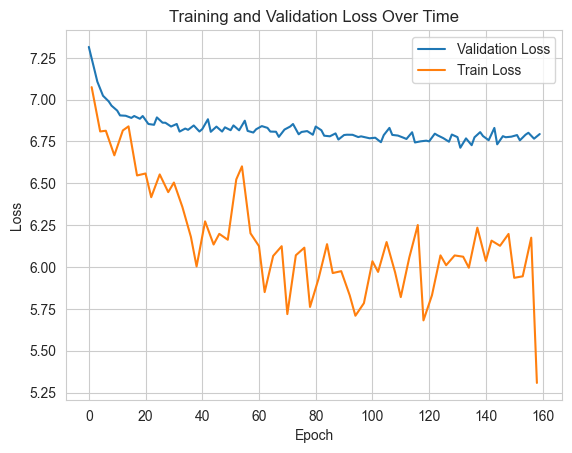

In [43]:
train_loss = log_df[-pd.isna(log_df.train_loss)]
valid_loss = log_df[-pd.isna(log_df.valid_loss)]
plt.plot(valid_loss['valid_loss'], label='Validation Loss')
plt.plot(train_loss['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

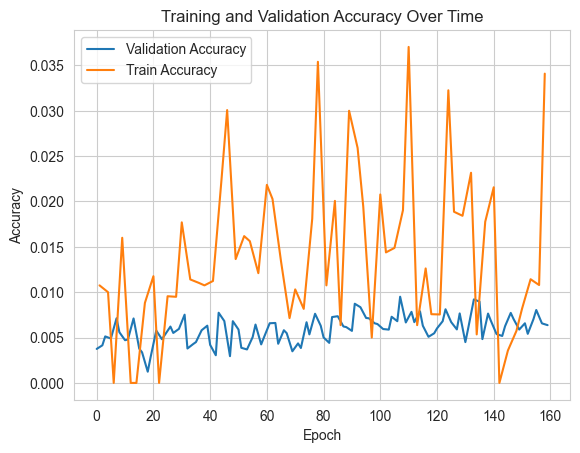

In [44]:
train_acc = log_df[-pd.isna(log_df.train_accuracy)]
valid_acc = log_df[-pd.isna(log_df.valid_accuracy)]
plt.plot(valid_acc['valid_accuracy'], label='Validation Accuracy')
plt.plot(train_acc['train_accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()
plt.show()

In [45]:
result_val = trainer.test(model, data_module.test_dataloader())
print(result_val[0])

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy        0.006800898816436529
        test_loss            6.771021842956543
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'test_loss': 6.771021842956543, 'test_accuracy': 0.006800898816436529}


## Result

In [46]:
movies = item_df[['movie id','movie title']]
movies.columns = ['id','title']
movie_to_idx = {a: mapping[b] for a, b in zip(movies.title.tolist(), movies.id.tolist()) if b in mapping}
idx_to_movie = {v: k for k, v in movie_to_idx.items()}

In [87]:
list_movies = ['Die Hard (1988)','Star Wars (1977)']
top_movie = predict_movie(list_movies, model, movie_to_idx, idx_to_movie)
top_movie[0:5]

['Return of the Jedi (1983)',
 'Liar Liar (1997)',
 'Contact (1997)',
 'Fargo (1996)',
 'Scream (1996)']

We try to use a case to demonstrates the effectiveness of our movie recommender system. Based on the movies that the user has already watched, such as 'Die Hard (1988)' and 'Star Wars (1977)', the system generates a list of recommended movies that includes 'Return of the Jedi (1983)', 'Liar Liar (1997)', 'Contact (1997)', 'Fargo (1996)', and 'Scream (1996)'.
1. It is obvious that 'Return of the Jedi (1983)' is also known as Star Wars: Episode VI – Return of the Jedi and is related to 'Star Wars (1977)', while 'Contact (1997)' is also a science fiction drama film.
2. Both 'Die Hard (1988)' and 'Fargo (1996)' belong to the crime or action movie genre.
3. Although 'Liar Liar (1997)' and 'Scream (1996)' are not primarily related to genre, the system has recognized their commercial success and critical acclaim, making them suitable recommendations for the user.

This example reiterates the importance of using personalized recommendations based on users' viewing habits and patterns, and the way our recommender system can effectively analyze these patterns to provide relevant suggestions.

## Conlusion

In this project, we have developed a movie recommendation system called BERT4Rec. This model is based on transformer layers and is trained using a similar approach to BERT, where we mask some elements of a user's movie history sequence and then try to predict the actual values of those items. BERT4Rec is designed to efficiently learn and extract complex semantic information during the movie recommendation process, including user behavior history and movie content features, enabling better understanding and fulfillment of users' interests and needs. This model can not only play an important role in the field of recommendation systems but can also be used as a general sequence learning algorithm in natural language processing and other sequence data tasks.

In future works, we plan to further improve the BERT4Rec model by incorporating additional sources of data - for example, demographic or social data of users that could provide more personalized recommendations. Additionally, we aim to explore new techniques for fine-tuning the model to maximize its accuracy and enhance the interpretability of its predictions.
Moreover, we plan to conduct extensive experiments to evaluate the effectiveness of the model on diverse datasets, as well as on various metrics such as recall, precision, and diversity. This will help us to better understand the strengths and limitations of the BERT4Rec model, and identify potential areas for further improvements.